In [1]:
import os

# Change the current working directory to your desired path
os.chdir('/Users/Yash/Downloads/aptos2019-blindness-detection')

# Verify the change
print('Current Working Directory is', os.getcwd())

Current Working Directory is /Users/Yash/Downloads/aptos2019-blindness-detection


In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from tqdm import tqdm, tqdm_notebook
from prettytable import PrettyTable
import pickle
import os
print('CWD is ', os.getcwd())

# Visualization Libraries
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["axes.grid"] = False

# Image Libraries
from PIL import Image
import cv2

from sklearn.model_selection import train_test_split

# Deep Learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import applications
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras import optimizers, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from multiprocessing.pool import ThreadPool
from sklearn.metrics import cohen_kappa_score, accuracy_score

CWD is  /Users/Yash/Downloads/aptos2019-blindness-detection


In [3]:
#reads data from csv files
def load_data():
    train = pd.read_csv('train.csv')
    test = pd.read_csv('test.csv')
    
    train_dir = os.path.join('./','train_images/')
    test_dir = os.path.join('./','test_images/')
    
    train['file_path'] = train['id_code'].map(lambda x: os.path.join(train_dir,'{}.png'.format(x)))
    test['file_path'] = test['id_code'].map(lambda x: os.path.join(test_dir,'{}.png'.format(x)))
    
    train['file_name'] = train["id_code"].apply(lambda x: x + ".png")
    test['file_name'] = test["id_code"].apply(lambda x: x + ".png")
    
    train['diagnosis'] = train['diagnosis'].astype(str)
    
    return train,test

In [4]:
df_train,df_test = load_data()
print(df_train.shape,df_test.shape,'\n')
df_train.head(6)

(3662, 4) (1928, 3) 



id_code diagnosis                        file_path         file_name
0  000c1434d8d7         2  ./train_images/000c1434d8d7.png  000c1434d8d7.png
1  001639a390f0         4  ./train_images/001639a390f0.png  001639a390f0.png
2  0024cdab0c1e         1  ./train_images/0024cdab0c1e.png  0024cdab0c1e.png
3  002c21358ce6         0  ./train_images/002c21358ce6.png  002c21358ce6.png
4  005b95c28852         0  ./train_images/005b95c28852.png  005b95c28852.png
5  0083ee8054ee         4  ./train_images/0083ee8054ee.png  0083ee8054ee.png

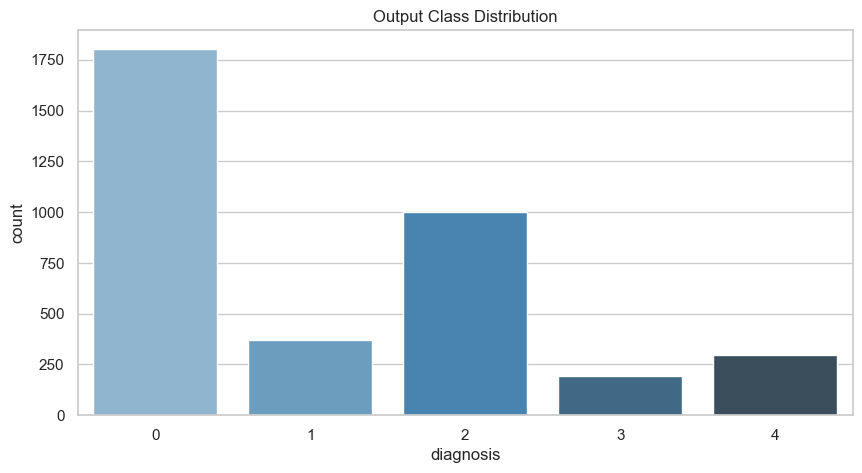

In [5]:
#plots a bar plot
def plot_classes(df):
    df_group = pd.DataFrame(df.groupby('diagnosis').agg('size').reset_index())
    df_group.columns = ['diagnosis','count']

    sns.set(rc={'figure.figsize':(10,5)}, style = 'whitegrid')
    sns.barplot(x = 'diagnosis',y='count',data = df_group,palette = "Blues_d")
    plt.title('Output Class Distribution')
    plt.show() 

plot_classes(df_train)

In [6]:
#there is class imbalance so we perform image augmentation


In [7]:
IMG_SIZE = 200

In [8]:
'''This Function converts a color image to gray scale image'''

def conv_gray(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    return img
  
    
'''
This Function shows the visual Image photo 
'''

def visualize_imgs(df,pts_per_class,color_scale):
    df = df.groupby('diagnosis',group_keys = False).apply(lambda df: df.sample(pts_per_class))
    df = df.reset_index(drop = True)
    
    plt.rcParams["axes.grid"] = False
    for pt in range(pts_per_class):
        f, axarr = plt.subplots(1,5,figsize = (15,15))
        axarr[0].set_ylabel("Sample Data Points")
        
        df_temp = df[df.index.isin([pt + (pts_per_class*0),pt + (pts_per_class*1), pt + (pts_per_class*2),pt + (pts_per_class*3),pt + (pts_per_class*4)])]
        for i in range(5):
            if color_scale == 'gray':
                img = conv_gray(cv2.imread(df_temp.file_path.iloc[i]))
                axarr[i].imshow(img,cmap = color_scale)
            else:
                axarr[i].imshow(Image.open(df_temp.file_path.iloc[i]).resize((IMG_SIZE,IMG_SIZE)))
            axarr[i].set_xlabel('Class '+str(df_temp.diagnosis.iloc[i]))

        plt.show()

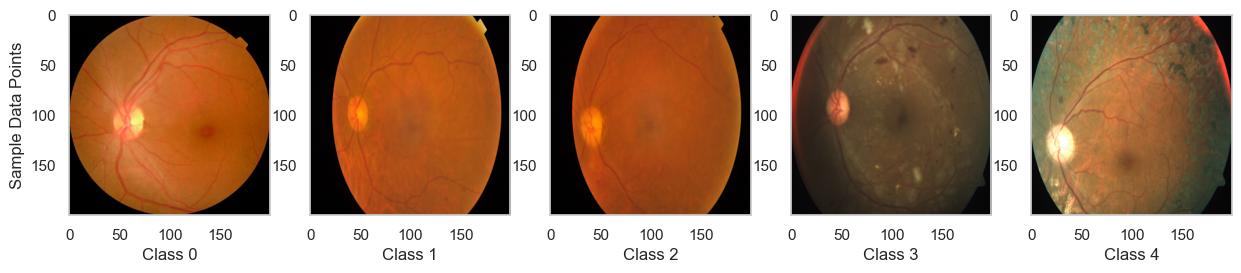

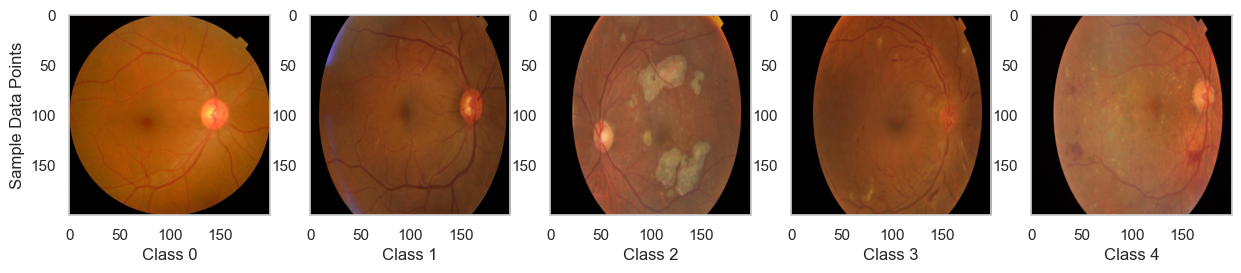

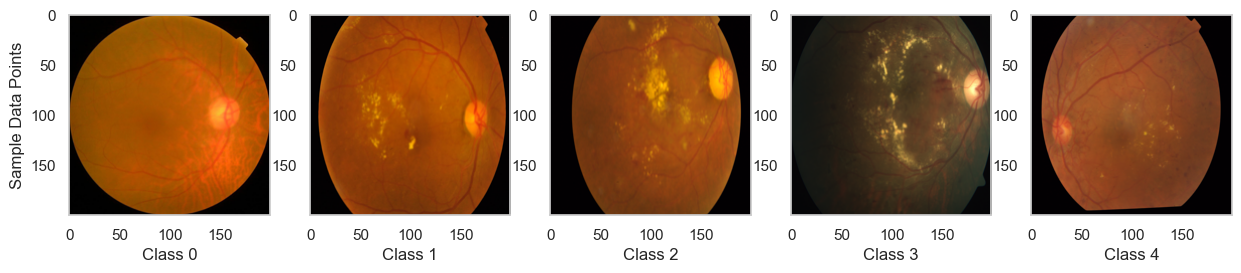

In [9]:
visualize_imgs(df_train,3,color_scale = None)

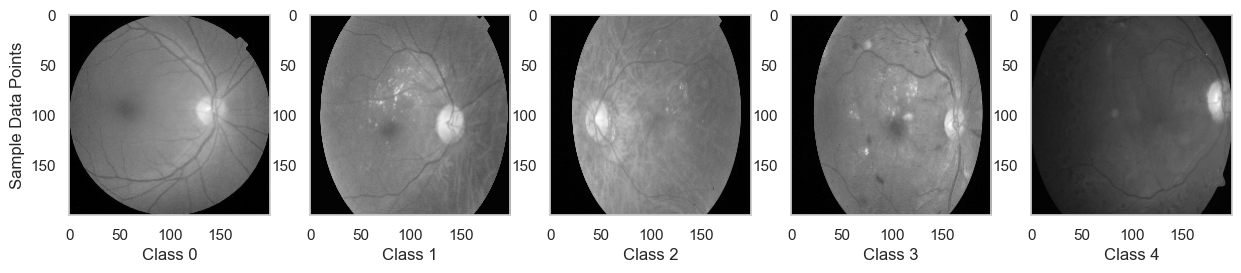

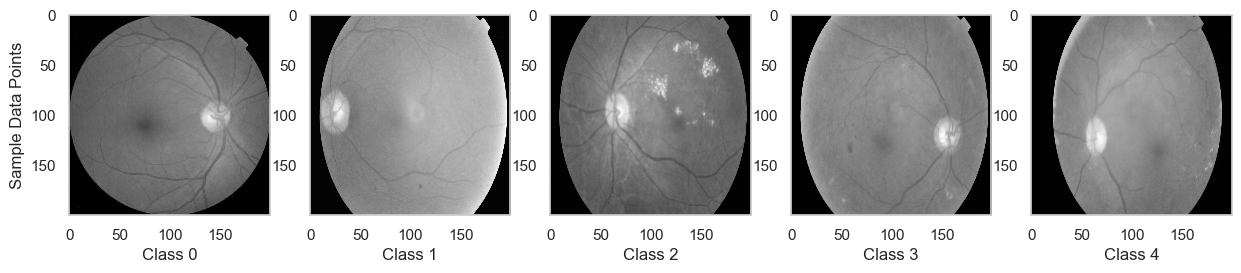

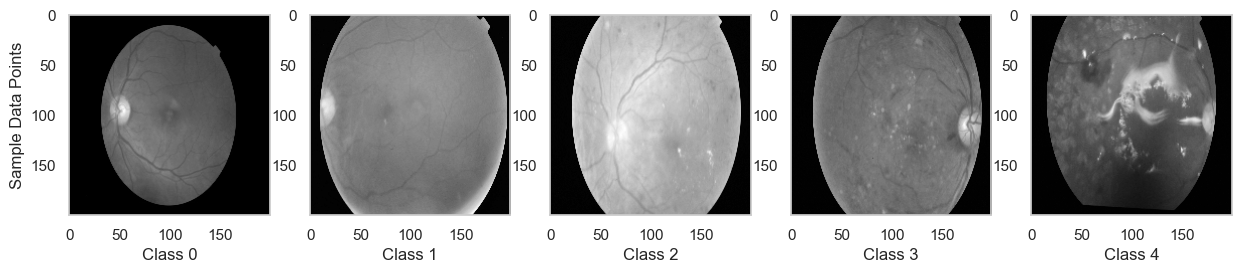

In [10]:
visualize_imgs(df_train,3,color_scale = 'gray')

In [11]:
#as we move from classes we see that abnoramlities are increasing and lighting conditions for the images is not even.

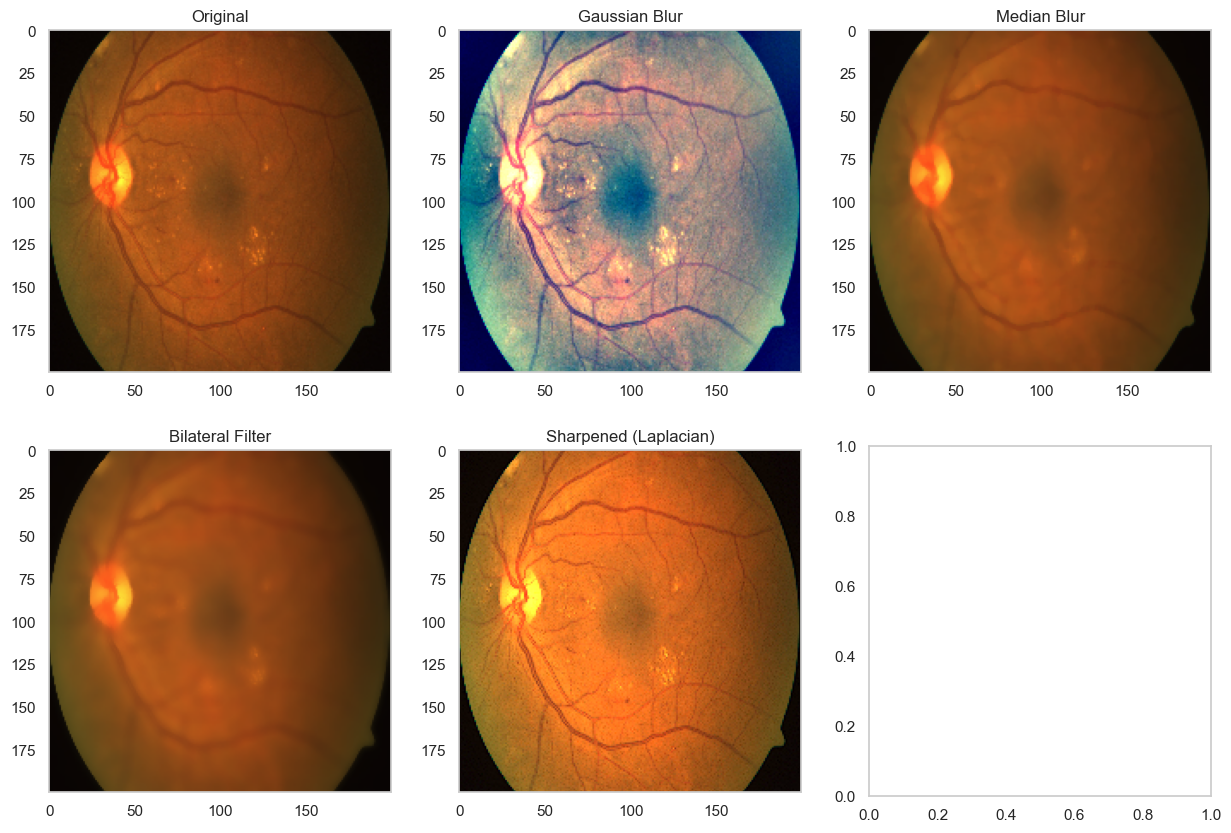

In [12]:
'''
This section of code applies gaussian blur on top of image
'''

rn = np.random.randint(low = 0,high = len(df_train) - 1)

img = cv2.imread(df_train.file_path.iloc[rn])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))

img_t = cv2.addWeighted(img,4, cv2.GaussianBlur(img , (0,0) , 30) ,-4 ,128)

img_median = cv2.medianBlur(img, 5)  # Kernel size 5

# Bilateral Filter
img_bilateral = cv2.bilateralFilter(img, 9, 75, 75)  # Diameter 9, sigmaColor 75, sigmaSpace 75

# Sharpening (Using Laplacian filter)
img_laplacian = cv2.Laplacian(img, cv2.CV_64F)
img_laplacian = np.clip(img_laplacian, 0, 255).astype(np.uint8)  # Convert to uint8

img_sharpened = cv2.addWeighted(img, 1.5, img_laplacian, -0.5, 0) 
img_sharpened = np.clip(img_sharpened, 0, 255).astype(np.uint8)

# Display results
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes[0, 0].imshow(img)
axes[0, 0].set_title('Original')
axes[0, 1].imshow(img_t)
axes[0, 1].set_title('Gaussian Blur')
axes[0, 2].imshow(img_median)
axes[0, 2].set_title('Median Blur')
axes[1, 0].imshow(img_bilateral)
axes[1, 0].set_title('Bilateral Filter')
axes[1, 1].imshow(img_sharpened)
axes[1, 1].set_title('Sharpened (Laplacian)')
plt.show()

In [13]:
#gaussian blur provides the best result when compared to differnet filters and that is why it is choosed


In [14]:

'''
This Function performs image processing on top of images by performing Gaussian Blur and Circle Crop
'''
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img
    
    
def circle_crop(img, sigmaX):   
    """
    Create circular crop around image centre    
    """    
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted(img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img 

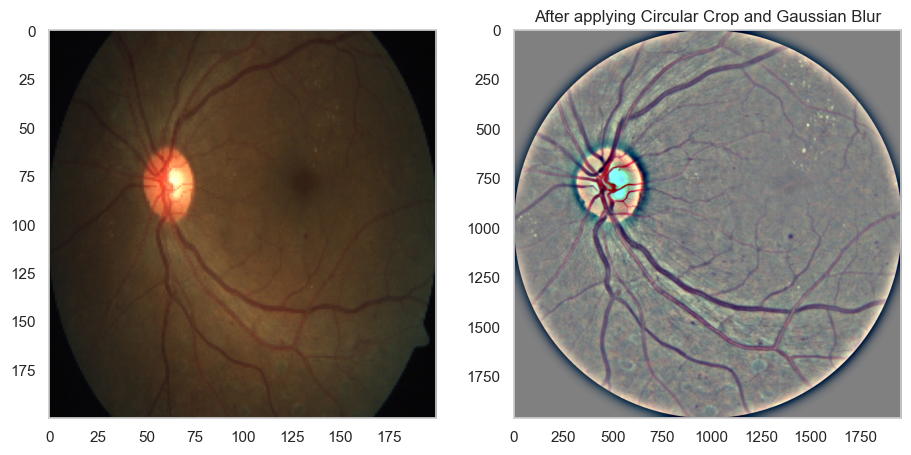

In [15]:
'''Perform Image Processing on a sample image'''

rn = np.random.randint(low = 0,high = len(df_train) - 1)

#img = img_t
img = cv2.imread(df_train.file_path.iloc[rn])
img_t = circle_crop(img,sigmaX = 30)

f, axarr = plt.subplots(1,2,figsize = (11,11))
axarr[0].imshow(cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB),(IMG_SIZE,IMG_SIZE)))
axarr[1].imshow(img_t)
plt.title('After applying Circular Crop and Gaussian Blur')
plt.show()

In [16]:
#Plot summary - As we can see above, now the image features and details are very much clearer than what the image was before, we are ready to use this image for modelling as the image details are much more clearer

In [17]:
'''
This Function shows the visual Image photo of 'n x 5' points (5 of each class) 
and performs image processing (Gaussian Blur, Circular crop) transformation on top of that
'''

def visualize_img_process(df,pts_per_class,sigmaX):
    df = df.groupby('diagnosis',group_keys = False).apply(lambda df: df.sample(pts_per_class))
    df = df.reset_index(drop = True)
    
    plt.rcParams["axes.grid"] = False
    for pt in range(pts_per_class):
        f, axarr = plt.subplots(1,5,figsize = (15,15))
        axarr[0].set_ylabel("Sample Data Points")
        
        df_temp = df[df.index.isin([pt + (pts_per_class*0),pt + (pts_per_class*1), pt + (pts_per_class*2),pt + (pts_per_class*3),pt + (pts_per_class*4)])]
        for i in range(5):
            img = cv2.imread(df_temp.file_path.iloc[i])
            img = circle_crop(img,sigmaX)
            axarr[i].imshow(img)
            axarr[i].set_xlabel('Class '+str(df_temp.diagnosis.iloc[i]))

        plt.show()

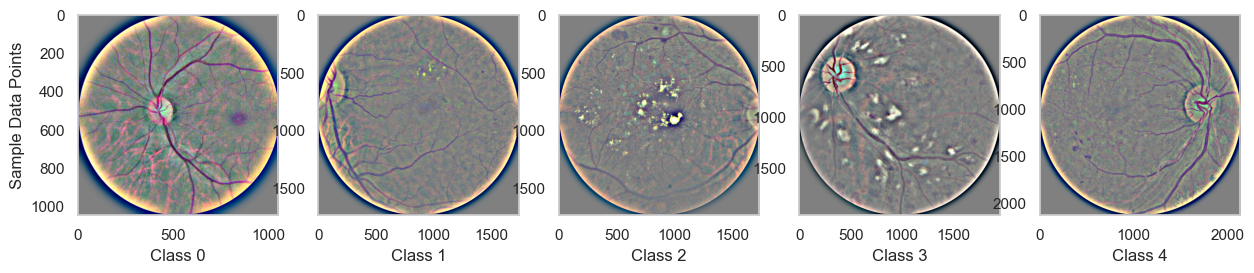

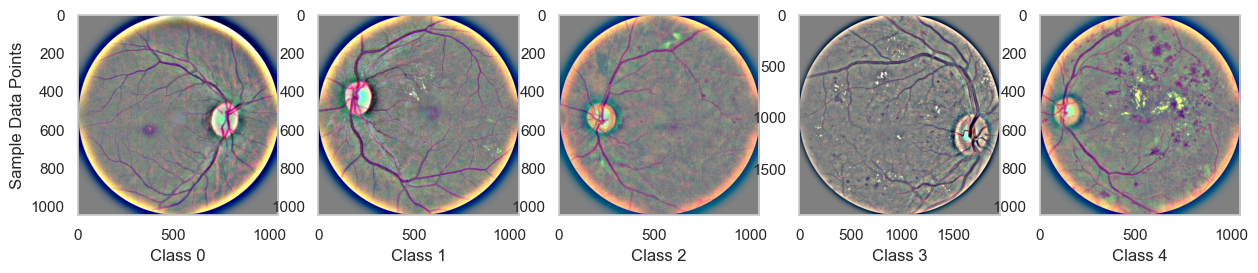

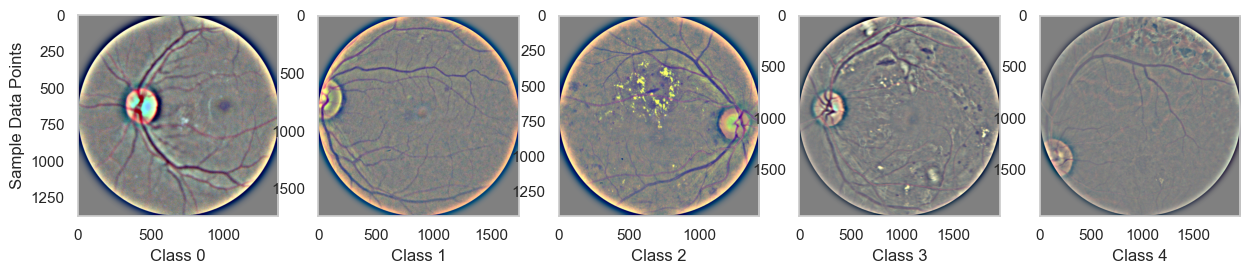

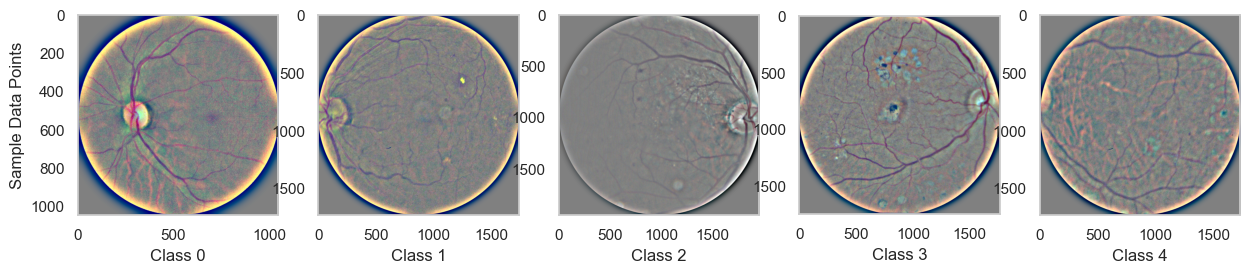

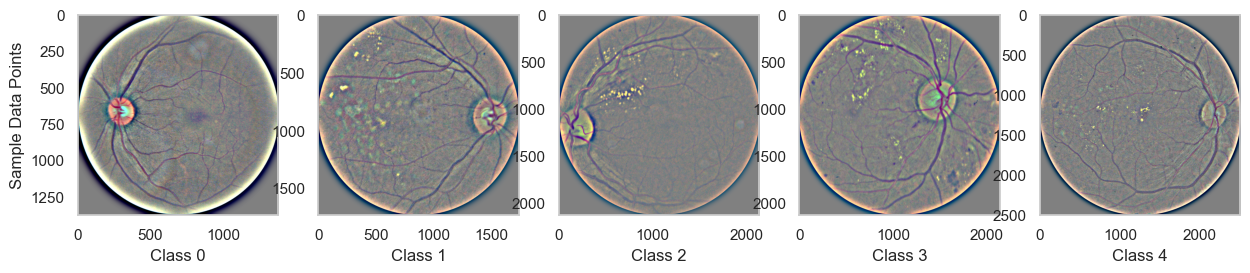

In [18]:
visualize_img_process(df_train,5,sigmaX = 30)

In [19]:
#t-sne application

In [20]:
# train image data
npix = 224 # resize to npix x npix (for now)
X_train = np.zeros((df_train.shape[0], npix, npix))
for i in tqdm_notebook(range(df_train.shape[0])):
    # load an image
    img = cv2.imread(df_train.file_path.iloc[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    X_train[i, :, :] = cv2.resize(img, (npix, npix)) 
    
print("X_train shape: " + str(np.shape(X_train)))   

  0%|          | 0/3662 [00:00<?, ?it/s]

X_train shape: (3662, 224, 224)


In [21]:
'''# normalize
X = X_train / 255

# reshape
X = X.reshape(X.shape[0], -1)
trainy = df_train['diagnosis']'''

"# normalize\nX = X_train / 255\n\n# reshape\nX = X.reshape(X.shape[0], -1)\ntrainy = df_train['diagnosis']"

In [22]:
'''per_vals = [2,5,10,15,20,30,40,50]

for per in tqdm(per_vals):
    X_decomposed = TSNE(n_components=2, perplexity=per).fit_transform(X)
    df_tsne = pd.DataFrame(data=X_decomposed, columns=['Dimension_x', 'Dimension_y'])
    df_tsne['Score'] = trainy.values

    sns.FacetGrid(df_tsne, hue='Score', height=6).map(plt.scatter, 'Dimension_x', 'Dimension_y').add_legend()
    plt.title('TSNE for perplexity = ' + str(per))
    plt.show()'''

"per_vals = [2,5,10,15,20,30,40,50]\n\nfor per in tqdm(per_vals):\n    X_decomposed = TSNE(n_components=2, perplexity=per).fit_transform(X)\n    df_tsne = pd.DataFrame(data=X_decomposed, columns=['Dimension_x', 'Dimension_y'])\n    df_tsne['Score'] = trainy.values\n\n    sns.FacetGrid(df_tsne, hue='Score', height=6).map(plt.scatter, 'Dimension_x', 'Dimension_y').add_legend()\n    plt.title('TSNE for perplexity = ' + str(per))\n    plt.show()"

In [23]:
#As we can see, we are able to seperate Class '0' from other classes (1-4). Seperating between classes 1-4 looks challenging.

In [24]:
#data augmentation

In [25]:
'''This Function generates 'lim' number of Image Augmentations from a random Image in the directory'''

def generate_augmentations(lim):
    datagen = ImageDataGenerator(featurewise_center=True,
                                 featurewise_std_normalization=True,
                                 rotation_range=20,
                                 #width_shift_range=0.2,
                                 #height_shift_range=0.2,
                                 horizontal_flip=True)
    img = cv2.imread(df_train.file_path.iloc[np.random.randint(low = 0,high = len(df_train) - 1)])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.title('ORIGINAL IMAGE')
    plt.show()
    
    img_arr = img.reshape((1,) + img.shape)
    
    i = 0
    for img_iterator in datagen.flow(x = img_arr,batch_size = 1):
        i = i + 1
        if i > lim:
            break
        plt.imshow((img_iterator.reshape(img_arr[0].shape)).astype(np.uint8))
        plt.title('IMAGE AUGMENTATION ' + str(i))
        plt.show() 

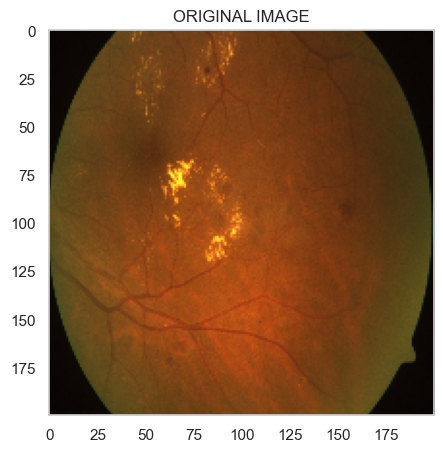

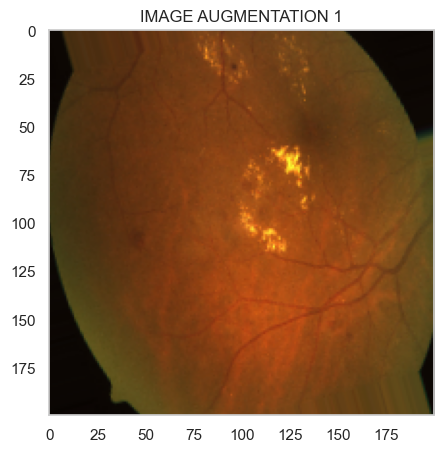

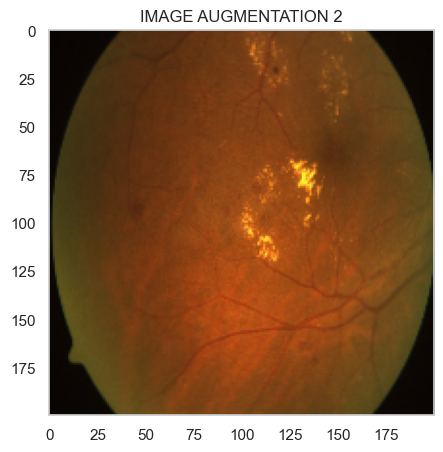

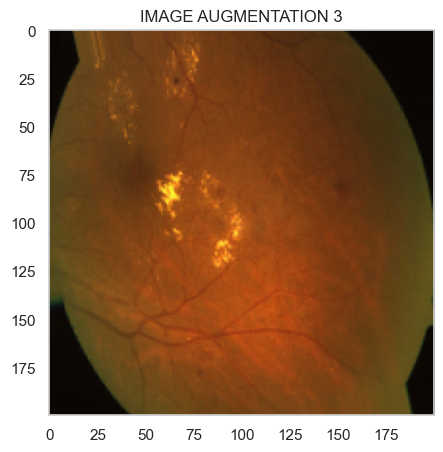

In [26]:
generate_augmentations(3)

In [27]:
#As we can see above, Image Augmentations are extremely helpful for this datasets to make our Models more Robust and would also have a higher ability to generalize well

In [28]:
#PROCESS

In [29]:
#training split

In [30]:
'''
This function reads data from the respective train and test directories
'''

def load_data():
    train = pd.read_csv('train.csv')
    test = pd.read_csv('test.csv')
    
    train_dir = os.path.join('./','train_images/')
    test_dir = os.path.join('./','test_images/')
    
    train['file_path'] = train['id_code'].map(lambda x: os.path.join(train_dir,'{}.png'.format(x)))
    test['file_path'] = test['id_code'].map(lambda x: os.path.join(test_dir,'{}.png'.format(x)))
    
    train['file_name'] = train["id_code"].apply(lambda x: x + ".png")
    test['file_name'] = test["id_code"].apply(lambda x: x + ".png")
    
    train['diagnosis'] = train['diagnosis'].astype(str)
    
    return train,test

In [31]:
df_train,df_test = load_data()
print(df_train.shape,df_test.shape,'\n')
df_train.head(6)

(3662, 4) (1928, 3) 



id_code diagnosis                        file_path         file_name
0  000c1434d8d7         2  ./train_images/000c1434d8d7.png  000c1434d8d7.png
1  001639a390f0         4  ./train_images/001639a390f0.png  001639a390f0.png
2  0024cdab0c1e         1  ./train_images/0024cdab0c1e.png  0024cdab0c1e.png
3  002c21358ce6         0  ./train_images/002c21358ce6.png  002c21358ce6.png
4  005b95c28852         0  ./train_images/005b95c28852.png  005b95c28852.png
5  0083ee8054ee         4  ./train_images/0083ee8054ee.png  0083ee8054ee.png

In [32]:
df_train_train,df_train_test = train_test_split(df_train,test_size = 0.2, random_state=42)
print(df_train_train.shape,df_train_test.shape)

(2929, 4) (733, 4)


In [33]:
'''This Function Plots a Bar plot of output Classes Distribution'''

def plot_classes(df,title):
    df_group = pd.DataFrame(df.groupby('diagnosis').agg('size').reset_index())
    df_group.columns = ['diagnosis','count']

    sns.set(rc={'figure.figsize':(10,5)}, style = 'whitegrid')
    sns.barplot(x = 'diagnosis',y='count',data = df_group,palette = "Blues_d")
    plt.title('Output Class Distribution ' + str(title))
    plt.show() 

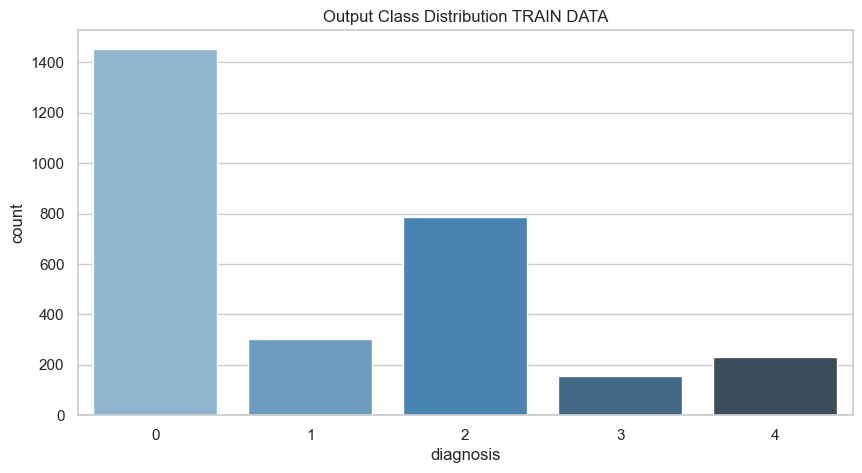

In [34]:
plot_classes(df_train_train,"TRAIN DATA")

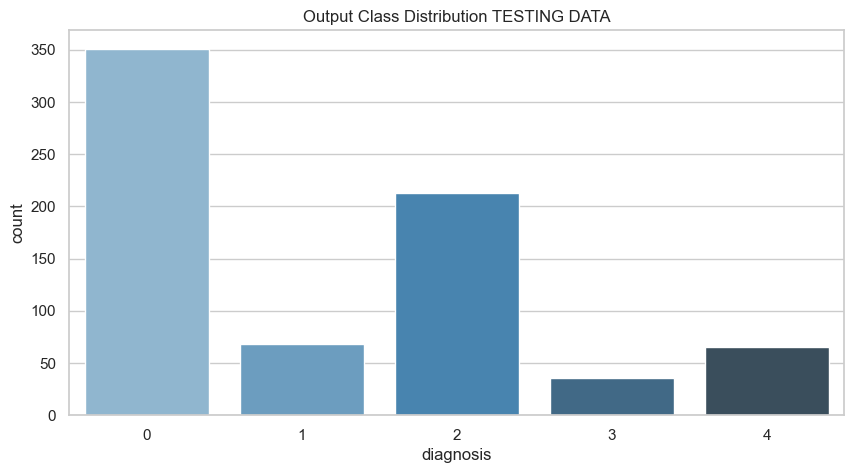

In [35]:
plot_classes(df_train_test,'TESTING DATA')

In [36]:
import os
print("Files in Current Directory:", os.listdir('/Users/Yash/Downloads/aptos 2015-2019 combined'))



Files in Current Directory: ['test_images', 'df_train_train.pkl', '.DS_Store', 'Diabetic Retinopathy Using Deep Learning.pdf', 'labels', 'df_train_test.pkl', 'train_images', 'df_train_valid.pkl']


In [37]:
# Use raw string for the path or ensure correct escaping
with open(r'/Users/Yash/Downloads/aptos2019-blindness-detection/df_train_train.pkl', 'wb') as file:
    pickle.dump(df_train_train, file)

with open(r'/Users/Yash/Downloads/aptos2019-blindness-detection/df_train_test.pkl', 'wb') as file:
    pickle.dump(df_train_test, file)

In [38]:
print(df_train_train.shape,df_train_test.shape)
print(len(os.listdir('./train_images_resized_preprocessed')),len(os.listdir('./test_images_resized_preprocessed')))

(2929, 4) (733, 4)
2929 2661


In [39]:
IMG_SIZE  = 512
'''Function loads an image from Folder , Resizes and saves in another directory '''

def image_resize_save(file):
    input_filepath = os.path.join('./','train_images','{}.png'.format(file))
    output_filepath = os.path.join('./','valid_images_resized','{}.png'.format(file))
    img = cv2.imread(input_filepath)
    cv2.imwrite(output_filepath, cv2.resize(img, (IMG_SIZE,IMG_SIZE)))
#image_resize_save(df_train.id_code.iloc[201])
'''This Function uses Multi processing for faster saving of images into folder'''

def multiprocess_image_downloader(process:int, imgs:list):
    """
    Inputs:
        process: (int) number of process to run
        imgs:(list) list of images
    """
    print(f'MESSAGE: Running {process} process')
    results = ThreadPool(process).map(image_resize_save, imgs)
    return results


In [40]:
multiprocess_image_downloader(6, list(df_train_test.id_code.values))

MESSAGE: Running 6 process


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [41]:
import cv2
import numpy as np
import os
from multiprocessing.pool import ThreadPool

def crop_image_from_gray(img, tol=7):
    if img is None:
        return None
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1), mask.any(0))]
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        check_shape = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))].shape[0]
        if check_shape == 0:  # image is too dark so that we crop out everything,
            return img  # return original image
        else:
            img1 = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))]
            img2 = img[:, :, 1][np.ix_(mask.any(1), mask.any(0))]
            img3 = img[:, :, 2][np.ix_(mask.any(1), mask.any(0))]
            img = np.stack([img1, img2, img3], axis=-1)
        return img

def circle_crop(img, sigmaX=30):
    if img is None:
        return None
    img = crop_image_from_gray(img)
    if img is None:
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    height, width, _ = img.shape
    x = int(width / 2)
    y = int(height / 2)
    r = np.amin((x, y))
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x, y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    if img is None:
        return None
    img = cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0, 0), sigmaX), -4, 128)
    return img

def preprocess_image(file):
    IMG_SIZE = 256  # Define your IMG_SIZE if not defined
    input_filepath = os.path.join('./test_images_resized', f'{file}.png')
    output_filepath = os.path.join('./test_images_resized_preprocessed', f'{file}.png')

    img = cv2.imread(input_filepath)
    if img is None:
        print(f"Failed to load image {file}")
        return
    img = circle_crop(img)
    if img is None:
        print(f"Failed to process image {file}")
        return
    cv2.imwrite(output_filepath, cv2.resize(img, (IMG_SIZE, IMG_SIZE)))

def multiprocess_image_processor(process, imgs):
    print(f'MESSAGE: Running {process} processes')
    results = ThreadPool(process).map(preprocess_image, imgs)
    return results

# Example call, assuming df_train_test has id_code attribute containing image filenames
#multiprocess_image_processor(6, list(df_train_test['id_code'].values))

In [42]:
'''import cv2
import numpy as np
import os
from multiprocessing.pool import ThreadPool

def crop_image_from_gray(img, tol=7):
    if img is None:
        return None
    if img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        check_shape = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))].shape[0]
        if check_shape == 0:
            return img  # return original image if too dark
        else:
            img1 = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))]
            img2 = img[:, :, 1][np.ix_(mask.any(1), mask.any(0))]
            img3 = img[:, :, 2][np.ix_(mask.any(1), mask.any(0))]
            img = np.stack([img1, img2, img3], axis=-1)
        return img

def circle_crop(img, sigmaX=30):
    if img is None:
        return None
    img = crop_image_from_gray(img)
    if img is None:
        return None
    height, width, _ = img.shape
    x = width // 2
    y = height // 2
    r = np.amin([x, y])  # Use x and y after they have been defined
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x, y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0, 0), sigmaX), -4, 128)
    return img

def preprocess_image(file_path):
    IMG_SIZE = 256
    img = cv2.imread(file_path)
    if img is None:
        print(f"Failed to load image {file_path}")
        return
    img = circle_crop(img)
    if img is None:
        print(f"Failed to process image {file_path}")
        return
    cv2.imwrite(file_path, cv2.resize(img, (IMG_SIZE, IMG_SIZE)))  # Overwrite original file

def process_directory(directory_path):
    files = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))]
    ThreadPool(6).map(preprocess_image, files)

# Example usage
directory1 = '/Users/Yash/Downloads/aptos2019-blindness-detection/train_images_resized_preprocessed'
directory2 = '/Users/Yash/Downloads/aptos2019-blindness-detection/test_images_resized_preprocessed'

process_directory(directory1)
process_directory(directory2)'''

'import cv2\nimport numpy as np\nimport os\nfrom multiprocessing.pool import ThreadPool\n\ndef crop_image_from_gray(img, tol=7):\n    if img is None:\n        return None\n    if img.ndim == 3:\n        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)\n        mask = gray_img > tol\n        check_shape = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))].shape[0]\n        if check_shape == 0:\n            return img  # return original image if too dark\n        else:\n            img1 = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))]\n            img2 = img[:, :, 1][np.ix_(mask.any(1), mask.any(0))]\n            img3 = img[:, :, 2][np.ix_(mask.any(1), mask.any(0))]\n            img = np.stack([img1, img2, img3], axis=-1)\n        return img\n\ndef circle_crop(img, sigmaX=30):\n    if img is None:\n        return None\n    img = crop_image_from_gray(img)\n    if img is None:\n        return None\n    height, width, _ = img.shape\n    x = width // 2\n    y = height // 2\n    r = np.amin([x, y

In [43]:
# Model parameters
BATCH_SIZE = 8
EPOCHS = 40
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 320
WIDTH = 320
CANAL = 3
N_CLASSES = df_train_train['diagnosis'].nunique()
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

In [44]:
def img_generator(train,test):
    train_datagen=ImageDataGenerator(rescale=1./255, validation_split=0.2,horizontal_flip=True)
    
    train_generator=train_datagen.flow_from_dataframe(dataframe=df_train_train,
                                                      directory="./train_images_resized_preprocessed/",
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="categorical",
                                                      target_size=(HEIGHT, WIDTH),
                                                      subset='training')
    
    valid_generator=train_datagen.flow_from_dataframe(dataframe=df_train_train,
                                                      directory="./train_images_resized_preprocessed/",
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="categorical",    
                                                      target_size=(HEIGHT, WIDTH),
                                                      subset='validation')
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_dataframe(dataframe=df_train_test,
                                                      directory = "./test_images_resized_preprocessed/",
                                                      x_col="file_name",
                                                      target_size=(HEIGHT, WIDTH),
                                                      batch_size=1,
                                                      shuffle=False,
                                                      class_mode=None)
    
    return train_generator,valid_generator,test_generator

In [45]:
train_generator,valid_generator,test_generator = img_generator(df_train_train,df_train_test)

Found 2344 validated image filenames belonging to 5 classes.
Found 585 validated image filenames belonging to 5 classes.
Found 733 validated image filenames.


In [74]:
def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = applications.ResNet50(weights='imagenet', include_top=False,input_tensor=input_tensor)
    #base_model.load_weights('resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(n_out, activation='softmax', name='final_output')(x)
    model = Model(input_tensor, final_output)
    return model

In [76]:
model = create_model(input_shape=(HEIGHT, WIDTH, CANAL), n_out=N_CLASSES)

for layer in model.layers:
    layer.trainable = False

for i in range(-5, 0):
    model.layers[i].trainable = True
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 320, 320,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 326, 326,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 160, 160,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 160, 160,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 160, 160,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 162, 162,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 80, 80,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 80, 80,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 80, 80,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 80, 80,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 80, 80,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 80, 80,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 80, 80,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 80, 80,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 80, 80,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 80, 80,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 80, 80,    │      1,024 │ conv2_block1_3_c

 Total params: 27,794,309 (106.03 MB)

 Trainable params: 4,206,597 (16.05 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [78]:
class ResetGeneratorWarmup(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Resetting generators after epoch {epoch + 1}")
        train_generator.reset()  # Reset the train generator
        valid_generator.reset()  # Reset the validation generator

# 2. Verify generator data output (for debugging)
data_batch, label_batch = next(train_generator)
print(f"Data batch shape: {data_batch.shape}, Labels batch shape: {label_batch.shape}")

# 3. Calculate steps per epoch and validation steps
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size
print(f"Steps per epoch: {STEP_SIZE_TRAIN}, Validation steps: {STEP_SIZE_VALID}")

# 4. Manually reset generators before training (ensure they start fresh)
train_generator.reset()
valid_generator.reset()


Data batch shape: (8, 320, 320, 3), Labels batch shape: (8, 5)
Steps per epoch: 293, Validation steps: 73


In [ ]:
# 5. Compile the model with the correct learning rate and loss function
model.compile(optimizer=optimizers.Adam(learning_rate=WARMUP_LEARNING_RATE),
              loss='categorical_crossentropy',  
              metrics=['accuracy'])

# 6. Define the callback list for warmup (ResetGeneratorWarmup used here)
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)
callback_list_warmup = [es, rlrop, ResetGeneratorWarmup()]

# 7. Train the model for the warmup phase (using ResetGeneratorWarmup)
history_warmup = model.fit(train_generator,
                           steps_per_epoch=STEP_SIZE_TRAIN,
                           validation_data=valid_generator,
                           validation_steps=STEP_SIZE_VALID,
                           epochs=WARMUP_EPOCHS,
                           verbose=1,
                           callbacks=callback_list_warmup)  # Ensure ResetGeneratorWarmup is included

# 8. After warmup, manually reset generators to start fresh for fine-tuning
print("Warmup completed. Resetting generators for fine-tuning.")
train_generator.reset()
valid_generator.reset()

Epoch 1/2
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.3991 - loss: 2.6554

In [114]:
# 9. Fine-tuning phase (set all layers trainable)
for layer in model.layers:
    layer.trainable = True

# 10. Compile the model again for the fine-tuning phase with a new learning rate
model.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy',  
              metrics=['accuracy'])
model.summary()

# 11. Fine-tune the model (no generator reset per epoch in fine-tuning)
callback_list_finetune = [es, rlrop]  # No need for ResetGenerator here during fine-tuning



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 320, 320,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 326, 326,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 160, 160,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 160, 160,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 160, 160,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 162, 162,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 80, 80,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 80, 80,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 80, 80,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 80, 80,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 80, 80,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 80, 80,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 80, 80,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 80, 80,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 80, 80,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 80, 80,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 80, 80,    │      1,024 │ conv2_block1_3_c

 Total params: 27,794,309 (106.03 MB)

 Trainable params: 27,741,189 (105.82 MB)

 Non-trainable params: 53,120 (207.50 KB)

Epoch 1/40
293/293 ━━━━━━━━━━━━━━━━━━━━ 513s 2s/step - accuracy: 0.7050 - loss: 0.9282 - val_accuracy: 0.4932 - val_loss: 1.5524 - learning_rate: 1.0000e-04
Epoch 2/40
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.3458 - learning_rate: 1.0000e-04
Epoch 3/40
293/293 ━━━━━━━━━━━━━━━━━━━━ 502s 2s/step - accuracy: 0.7950 - loss: 0.5786 - val_accuracy: 0.5308 - val_loss: 1.3798 - learning_rate: 1.0000e-04
Epoch 4/40
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.2457 - learning_rate: 1.0000e-04
Epoch 5/40
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8329 - loss: 0.4632
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
293/293 ━━━━━━━━━━━━━━━━━━━━ 501s 2s/step - accuracy: 0.8328 - loss: 0.4633 - val_accuracy: 0.5291 - val_loss: 2.0811 - learning_rate: 1.0000e-04
Epoch 6/40
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 

2024-09-26 22:42:55.630607: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


293/293 ━━━━━━━━━━━━━━━━━━━━ 502s 2s/step - accuracy: 0.8344 - loss: 0.4371 - val_accuracy: 0.7740 - val_loss: 0.7943 - learning_rate: 5.0000e-05
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 2.


In [115]:
history_finetuning = model.fit(train_generator,
                               steps_per_epoch=STEP_SIZE_TRAIN,
                               validation_data=valid_generator,
                               validation_steps=STEP_SIZE_VALID,
                               epochs=EPOCHS,
                               verbose=1,
                               callbacks=callback_list_finetune)  # No ResetGenerator during fine-tuning

Epoch 1/40
293/293 ━━━━━━━━━━━━━━━━━━━━ 501s 2s/step - accuracy: 0.7755 - loss: 0.5933 - val_accuracy: 0.5325 - val_loss: 1.4323 - learning_rate: 5.0000e-05
Epoch 2/40
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.2131 - learning_rate: 5.0000e-05
Epoch 3/40
293/293 ━━━━━━━━━━━━━━━━━━━━ 503s 2s/step - accuracy: 0.8183 - loss: 0.4527 - val_accuracy: 0.6558 - val_loss: 1.1986 - learning_rate: 5.0000e-05
Epoch 4/40
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 4.4668 - learning_rate: 5.0000e-05
Epoch 5/40
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8623 - loss: 0.3820
Epoch 5: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
293/293 ━━━━━━━━━━━━━━━━━━━━ 512s 2s/step - accuracy: 0.8623 - loss: 0.3820 - val_accuracy: 0.7842 - val_loss: 0.7227 - learning_rate: 5.0000e-05
Epoch 6/40
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 

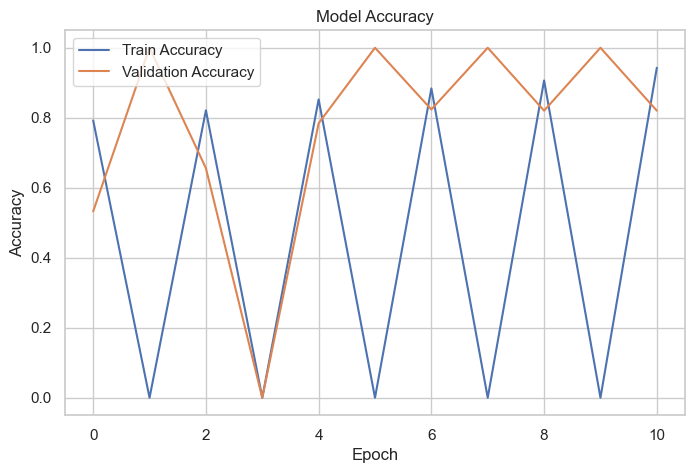

In [172]:
plt.figure(figsize=(8, 5))

# Accessing accuracy and validation accuracy from the history object
plt.plot(history_finetuning.history['accuracy'], label='Train Accuracy')
plt.plot(history_finetuning.history['val_accuracy'], label='Validation Accuracy')

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [176]:
complete_generator = complete_datagen.flow_from_dataframe(dataframe=df_train_train,
                                                          directory="./train_images_resized_preprocessed/",
                                                          x_col="file_name",
                                                          y_col=None,
                                                          target_size=(HEIGHT, WIDTH),
                                                          batch_size=BATCH_SIZE,
                                                          shuffle=False,
                                                          class_mode=None)

STEP_SIZE_COMPLETE = complete_generator.n // complete_generator.batch_size

# Use predict instead of predict_generator
train_preds = model.predict(complete_generator, steps=STEP_SIZE_COMPLETE, verbose=1)

# Convert predictions to class indices
train_preds = [np.argmax(pred) for pred in train_preds]

Found 2929 validated image filenames.
366/366 ━━━━━━━━━━━━━━━━━━━━ 137s 373ms/step


In [184]:
print(f"Length of train_preds: {len(train_preds)}")
print(f"Length of actual labels: {len(df_train_train['diagnosis'])}")

Length of train_preds: 2928
Length of actual labels: 2929


In [186]:
min_length = min(len(train_preds), len(df_train_train['diagnosis']))

train_preds = train_preds[:min_length]
actual_labels = df_train_train['diagnosis'].astype('int')[:min_length]

In [188]:
print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds, actual_labels, weights='quadratic'))
print("Train Accuracy score: %.3f" % accuracy_score(actual_labels, train_preds))

Train Cohen Kappa score: 0.825
Train Accuracy score: 0.811


In [192]:
# Reset test generator
test_generator.reset()

# Calculate the number of steps for the test set
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size

# Use predict() instead of predict_generator()
test_preds = model.predict(test_generator, steps=STEP_SIZE_TEST, verbose=1)

# Convert predictions to class indices
test_labels = [np.argmax(pred) for pred in test_preds]

733/733 ━━━━━━━━━━━━━━━━━━━━ 55s 74ms/step


In [194]:
print("Test Cohen Kappa score: %.3f" % cohen_kappa_score(test_labels, df_train_test['diagnosis'].astype('int'), weights='quadratic'))
print("Test Accuracy score : %.3f" % accuracy_score(df_train_test['diagnosis'].astype('int'),test_labels))


Test Cohen Kappa score: 0.807
Test Accuracy score : 0.780


In [222]:
#EFFICIENT NET


In [228]:
HEIGHT = 224
WIDTH = 224
CHANNELS = 3
BATCH_SIZE = 32
EPOCHS_WARMUP = 5
EPOCHS_FINE_TUNING = 40
WARMUP_LEARNING_RATE = 1e-3
FINE_TUNING_LEARNING_RATE = 1e-5

# Data Augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)

# Load training and validation data from DataFrame
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train_train,         # Your DataFrame with image paths and labels
    directory="./train_images_resized_preprocessed/",
    x_col="file_name",                # Column for image filenames
    y_col="diagnosis",                # Column for labels (diagnosis)
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=df_train_test,          # Your validation DataFrame
    directory="./test_images_resized_preprocessed/",
    x_col="file_name",                # Column for image filenames
    y_col="diagnosis",                # Column for labels (diagnosis)
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 2929 validated image filenames belonging to 5 classes.
Found 733 validated image filenames belonging to 5 classes.


In [240]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers during the warmup phase
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of EfficientNetB0
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(5, activation='softmax')(x)  # Assuming 5 classes

# Create the model
efficientnet_model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model for the warmup phase with a higher learning rate
efficientnet_model.compile(optimizer=optimizers.Adam(learning_rate=WARMUP_LEARNING_RATE),
                           loss='categorical_crossentropy', 
                           metrics=['accuracy'])

# Callbacks: ReduceLROnPlateau and EarlyStopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# Warmup phase training: Train the top layers only
history_warmup = efficientnet_model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    validation_data=valid_generator,
    validation_steps=valid_generator.n // valid_generator.batch_size,
    epochs=EPOCHS_WARMUP,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/5
91/91 ━━━━━━━━━━━━━━━━━━━━ 85s 877ms/step - accuracy: 0.4136 - loss: 2.8492 - val_accuracy: 0.4759 - val_loss: 1.5616 - learning_rate: 0.0010
Epoch 2/5
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5938 - loss: 1.5479 - val_accuracy: 0.5517 - val_loss: 1.5570 - learning_rate: 0.0010
Epoch 3/5
91/91 ━━━━━━━━━━━━━━━━━━━━ 77s 824ms/step - accuracy: 0.4896 - loss: 1.5605 - val_accuracy: 0.4773 - val_loss: 1.5119 - learning_rate: 0.0010
Epoch 4/5
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.4688 - loss: 1.5049 - val_accuracy: 0.5172 - val_loss: 1.4953 - learning_rate: 0.0010
Epoch 5/5
91/91 ━━━━━━━━━━━━━━━━━━━━ 78s 829ms/step - accuracy: 0.4786 - loss: 1.5050 - val_accuracy: 0.4815 - val_loss: 1.4683 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 5.


In [246]:
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Compile the model with a lower learning rate for fine-tuning
efficientnet_model.compile(optimizer=optimizers.Adam(learning_rate=FINE_TUNING_LEARNING_RATE),
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])

# Fine-tuning phase: Train the entire model
history_finetuning = efficientnet_model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    validation_data=valid_generator,
    validation_steps=valid_generator.n // valid_generator.batch_size,
    epochs=EPOCHS_FINE_TUNING,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/40
91/91 ━━━━━━━━━━━━━━━━━━━━ 90s 916ms/step - accuracy: 0.3804 - loss: 4.1279 - val_accuracy: 0.4773 - val_loss: 1.3099 - learning_rate: 1.0000e-05
Epoch 2/40
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.3438 - loss: 1.7626 - val_accuracy: 0.5172 - val_loss: 1.2461 - learning_rate: 1.0000e-05
Epoch 3/40
91/91 ━━━━━━━━━━━━━━━━━━━━ 80s 854ms/step - accuracy: 0.4469 - loss: 1.3762 - val_accuracy: 0.4815 - val_loss: 1.3441 - learning_rate: 1.0000e-05
Epoch 4/40
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5000 - loss: 1.3854 - val_accuracy: 0.4138 - val_loss: 1.2755 - learning_rate: 1.0000e-05
Epoch 5/40
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.4800 - loss: 1.3559
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
91/91 ━━━━━━━━━━━━━━━━━━━━ 81s 862ms/step - accuracy: 0.4800 - loss: 1.3560 - val_accuracy: 0.4801 - val_loss: 1.3779 - learning_rate: 1.0000e-05
Epoch 6/40
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.406

In [252]:
train_generator.reset()
train_steps = train_generator.n // train_generator.batch_size + (train_generator.n % train_generator.batch_size != 0)
train_preds = efficientnet_model.predict(train_generator, steps=train_steps, verbose=1)

# Convert predictions from probabilities to class labels
train_preds_classes = np.argmax(train_preds, axis=1)

# Evaluate on the test set (validation set here)
valid_generator.reset()
valid_steps = valid_generator.n // valid_generator.batch_size + (valid_generator.n % valid_generator.batch_size != 0)
valid_preds = efficientnet_model.predict(valid_generator, steps=valid_steps, verbose=1)

# Convert predictions from probabilities to class labels
valid_preds_classes = np.argmax(valid_preds, axis=1)

# Get true labels from the generators
train_true_labels = train_generator.classes[:train_preds_classes.shape[0]]  # Adjust to match prediction length
valid_true_labels = valid_generator.classes[:valid_preds_classes.shape[0]]  # Adjust to match prediction length

# Calculate accuracy for train and validation (test) sets
train_accuracy = accuracy_score(train_true_labels, train_preds_classes)
valid_accuracy = accuracy_score(valid_true_labels, valid_preds_classes)

# Calculate Cohen Kappa score for train and validation (test) sets
train_kappa = cohen_kappa_score(train_true_labels, train_preds_classes, weights='quadratic')
valid_kappa = cohen_kappa_score(valid_true_labels, valid_preds_classes, weights='quadratic')

# Print the results
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {valid_accuracy:.4f}")


92/92 ━━━━━━━━━━━━━━━━━━━━ 33s 356ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step
Train Accuracy: 0.4964
Test Accuracy: 0.4789
